In [1]:
from triqs.gf import *
import numpy as np
from math import pi
class IPTSolver:
    def __init__(self, beta):
        self.beta = beta

        # Matsubara frequency Green's functions
        iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_iw=1001)
        self.G_iw = Gf(mesh=iw_mesh, target_shape=[1,1])
        self.G0_iw = self.G_iw.copy() # self.G0 will be set by the user after initialization
        self.Sigma_iw = self.G_iw.copy()

        # Imaginary time
        tau_mesh = MeshImTime(beta=beta, S='Fermion', n_tau=10001)
        self.G0_tau = Gf(mesh=tau_mesh, target_shape=[1,1])
        self.Sigma_tau = self.G0_tau.copy()

    def solve(self, U):
        self.G0_tau << Fourier(self.G0_iw)
        self.Sigma_tau << (U**2) * self.G0_tau * self.G0_tau * self.G0_tau
        self.Sigma_iw << Fourier(self.Sigma_tau)

        # Dyson
        self.G_iw << inverse(inverse(self.G0_iw) - self.Sigma_iw)

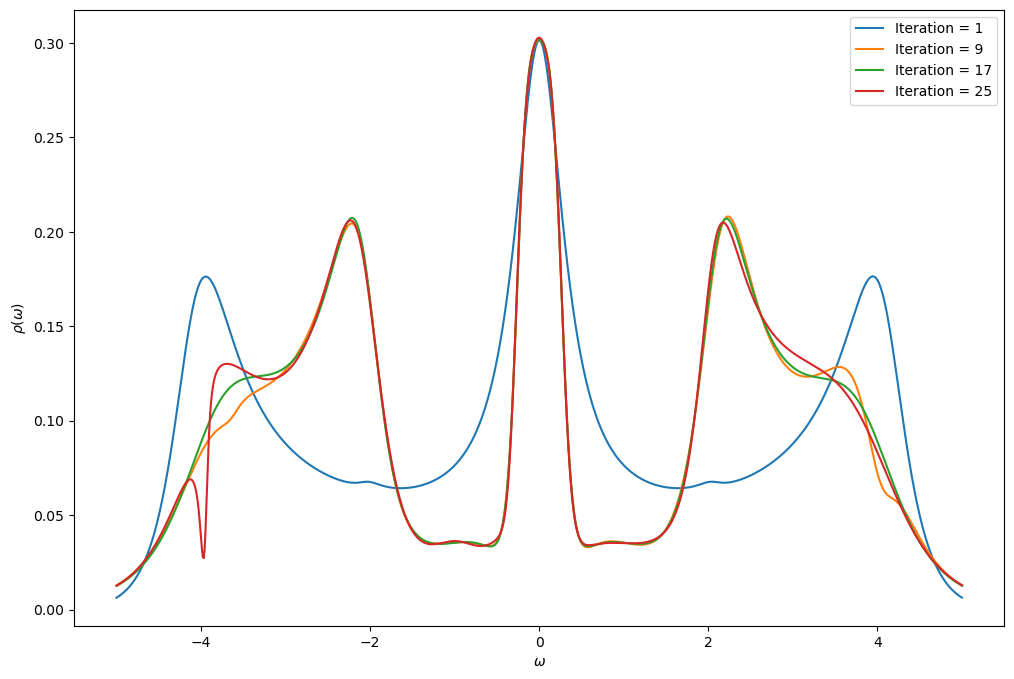

In [2]:
from triqs.plot.mpl_interface import *
%matplotlib inline
# change scale of all figures to make them bigger
import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

t = 1.0
U = 5.0
beta = 20
n_loops = 25

S = IPTSolver(beta = beta)
S.G_iw << SemiCircular(2*t)

fig = plt.figure(figsize=(12,8))

for i in range(n_loops):
    S.G0_iw << inverse( iOmega_n - t**2 * S.G_iw )
    S.solve(U = U)

    # Get real axis function with Pade approximation
    G_w = Gf(mesh=MeshReFreq(window = (-5.0,5.0), n_w=1000), target_shape=[1,1])
    G_w.set_from_pade(S.G_iw, 100, 0.01)

    if i % 8 == 0:
        oplot(-G_w.imag/pi, figure = fig, label = "Iteration = %i" % (i+1), name=r"$\rho$")
        

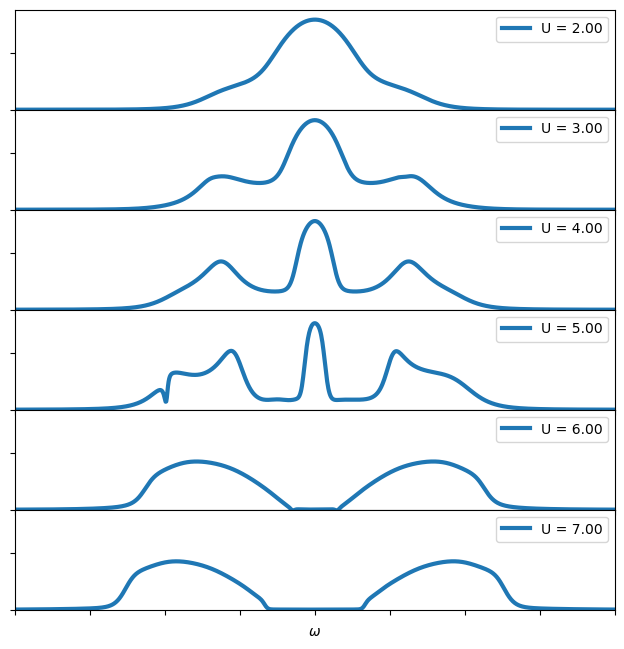

In [3]:
import numpy as np

# Parameters of the model
t = 1.0
beta = 20
n_loops = 25

fig = plt.figure(figsize=(6,6))
pn = 0 # iteration counter for plotting

for U in np.arange(2.0, 7.5, 1.0):

    S = IPTSolver(beta = beta)
    S.G_iw << SemiCircular(2*t)

    # DMFT
    for i in range(n_loops):
        S.G0_iw << inverse( iOmega_n - t**2 * S.G_iw )
        S.solve(U)

    # Get the real-axis with Pade approximation
    G_w = Gf(mesh=MeshReFreq(window=(-8.0,8.0), n_w=1000), target_shape=[1,1])
    G_w.set_from_pade(S.G_iw, 100, 0.01)

    # plotting
    ax = fig.add_axes([0,1.-(pn+1)/6.,1,1./6.]) # subplot
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    oplot(-G_w.imag/pi, linewidth=3, label = "U = %.2f" % U)
    plt.xlim(-8,8)
    plt.ylim(0,0.35)
    plt.ylabel("")
    pn = pn + 1